In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [5]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

engine.dispose()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [7]:
df.head(5)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


# EDA

## Handling Null Categorical Variables

According to the codebook, any None values in categorical data are meant as None, or non existent.  Hence None will be replaced with 'None'.

In [8]:
categorical_columns = df.select_dtypes('object').columns
for col in categorical_columns:
    df[col].fillna('None',inplace=True)

In [9]:
nulls = df.isnull().sum()
nulls[nulls!=0]

lotfrontage    259
masvnrarea       8
garageyrblt     81
dtype: int64

The remaining nulls will be dealt with later

## Adjusting Columns

As id will not be needed with regression, it will be dropped

In [10]:
df.drop('id',axis=1,inplace=True)

There are columns having numeric datatypes that are actually categorical.  I will deal with this after selecting which features to use.

## Handling Outliers

In [11]:
def categorical_outliers(df_class,df_output):
    ol = []
    for val in df[df_class].unique():
        class_stats = df[df[df_class]==val][df_output].describe()
        firstq = class_stats['25%']
        thirdq = class_stats['75%']
        iqr15 = 1.5 * (thirdq - firstq)
        lst = list(df[(df[df_class]==val)&((df[df_output] > thirdq + iqr15)|(df[df_output]<firstq-iqr15))].index)
        if len(lst) > 0:
            ol = ol + lst
    return ol

### Saleprice

(array([  5.,  11.,  13.,  61.,  58., 126., 165., 180., 122., 130., 121.,
         78.,  61.,  64.,  49.,  36.,  36.,  25.,  13.,  25.,  16.,  11.,
          4.,  11.,   9.,   5.,   4.,   4.,   4.,   2.,   1.,   1.,   1.,
          0.,   1.,   0.,   2.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 34900.,  49302.,  63704.,  78106.,  92508., 106910., 121312.,
        135714., 150116., 164518., 178920., 193322., 207724., 222126.,
        236528., 250930., 265332., 279734., 294136., 308538., 322940.,
        337342., 351744., 366146., 380548., 394950., 409352., 423754.,
        438156., 452558., 466960., 481362., 495764., 510166., 524568.,
        538970., 553372., 567774., 582176., 596578., 610980., 625382.,
        639784., 654186., 668588., 682990., 697392., 711794., 726196.,
        740598., 755000.]),
 <BarContainer object of 50 artists>)

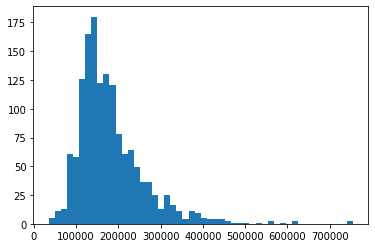

In [12]:
plt.hist(df.saleprice,bins=50)

Saleprice looks skewed.  Will create a log transformed saleprice to help search for outliers.

(array([  2.,   2.,   1.,   0.,   0.,   0.,   2.,   3.,   4.,   3.,   5.,
          1.,   5.,  21.,  22.,  23.,  18.,  29.,  58.,  56.,  65., 100.,
        122.,  93.,  90.,  82., 108.,  91.,  64.,  55.,  58.,  51.,  46.,
         42.,  23.,  29.,  22.,  13.,  13.,  13.,   7.,   5.,   4.,   1.,
          2.,   2.,   2.,   0.,   0.,   2.]),
 array([10.46024211, 10.52172673, 10.58321134, 10.64469596, 10.70618058,
        10.7676652 , 10.82914982, 10.89063444, 10.95211906, 11.01360367,
        11.07508829, 11.13657291, 11.19805753, 11.25954215, 11.32102677,
        11.38251138, 11.443996  , 11.50548062, 11.56696524, 11.62844986,
        11.68993448, 11.75141909, 11.81290371, 11.87438833, 11.93587295,
        11.99735757, 12.05884219, 12.12032681, 12.18181142, 12.24329604,
        12.30478066, 12.36626528, 12.4277499 , 12.48923452, 12.55071913,
        12.61220375, 12.67368837, 12.73517299, 12.79665761, 12.85814223,
        12.91962684, 12.98111146, 13.04259608, 13.1040807 , 13.16556532,
 

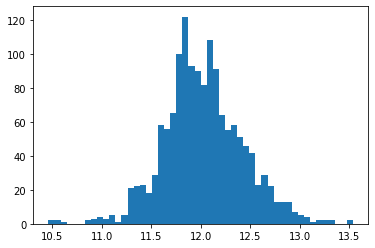

In [13]:
df['log_saleprice'] = np.log(df.saleprice)
plt.hist(df.log_saleprice, bins = 50)

This looks more symmetric.  Will first see how many outliers are with 1.5IQR.

In [14]:
# I changed to 2IQR as 1.5IQR presented too many outliers

log_saleprice_stats = df.log_saleprice.describe()
log_saleprice_3rdq = log_saleprice_stats['75%']
log_saleprice_1stq = log_saleprice_stats['25%']
log_saleprice_15iqr = 2*(log_saleprice_3rdq-log_saleprice_1stq)
outliers = list(df[(df.log_saleprice < log_saleprice_1stq-log_saleprice_15iqr)|
              (df.log_saleprice>log_saleprice_3rdq+log_saleprice_15iqr)].index)
outliers

[30, 496, 533, 691, 803, 898, 916, 968, 1169, 1182]

### MSSubclass

<AxesSubplot:title={'center':'saleprice'}, xlabel='mssubclass'>

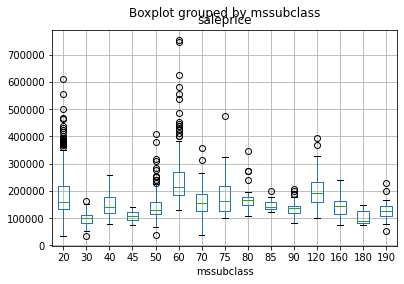

In [15]:
df.boxplot('saleprice','mssubclass')

All seem skewed, going to replot using log saleprice

<AxesSubplot:title={'center':'log_saleprice'}, xlabel='mssubclass'>

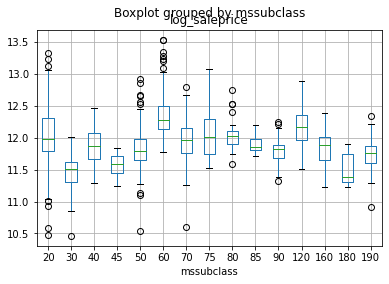

In [16]:
df.boxplot('log_saleprice','mssubclass')

In [17]:
outliers = outliers + categorical_outliers('mssubclass','log_saleprice')

### MSZoning

<AxesSubplot:title={'center':'log_saleprice'}, xlabel='mszoning'>

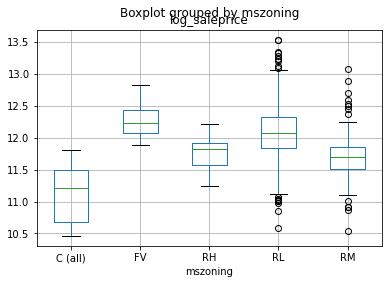

In [18]:
df.boxplot('log_saleprice','mszoning')

In [19]:
outliers = outliers+categorical_outliers('mszoning','log_saleprice')

### LotFrontage

(array([ 42.,  11.,  32.,  44.,  76.,  67., 183., 116., 147., 130., 141.,
         60.,  39.,  35.,  23.,  12.,  13.,   6.,   6.,   3.,   3.,   2.,
          3.,   1.,   0.,   1.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.]),
 array([ 21.  ,  26.84,  32.68,  38.52,  44.36,  50.2 ,  56.04,  61.88,
         67.72,  73.56,  79.4 ,  85.24,  91.08,  96.92, 102.76, 108.6 ,
        114.44, 120.28, 126.12, 131.96, 137.8 , 143.64, 149.48, 155.32,
        161.16, 167.  , 172.84, 178.68, 184.52, 190.36, 196.2 , 202.04,
        207.88, 213.72, 219.56, 225.4 , 231.24, 237.08, 242.92, 248.76,
        254.6 , 260.44, 266.28, 272.12, 277.96, 283.8 , 289.64, 295.48,
        301.32, 307.16, 313.  ]),
 <BarContainer object of 50 artists>)

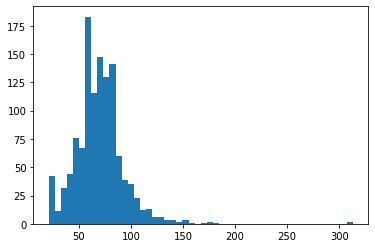

In [20]:
plt.hist(df.lotfrontage, bins=50)

Because of the skew, to search for outliers I will use 2*IQR

In [21]:
lf_stats = df.lotfrontage.describe()
firstq = lf_stats['25%']
thirdq = lf_stats['75%']
iqr2 = 2*(thirdq-firstq)
lf_outliers = list(df[(df.lotfrontage < firstq-iqr2)|(df.lotfrontage>thirdq+iqr2)].index)
lf_outliers # not sure if I should log

[160,
 172,
 198,
 232,
 277,
 278,
 314,
 430,
 447,
 523,
 807,
 889,
 909,
 934,
 966,
 1107,
 1127,
 1151,
 1173,
 1182,
 1211,
 1273,
 1298,
 1337,
 1359,
 1361]

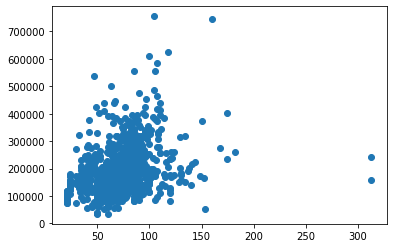

In [22]:
plt.scatter(df.lotfrontage,df.saleprice)

The relationship doesn't appear very linear.  However there are definite outliers where lotfrontage > 300.  These should have been captured above

In [23]:
outliers = outliers + lf_outliers

### LotArea

(array([  1.,   5.,  11.,   7.,   7.,   9.,  12.,   3.,  18.,   6.,  16.,
         23.,  20.,  32.,  40.,  44.,  88., 120., 187., 201., 178., 149.,
         91.,  70.,  40.,  22.,   8.,  15.,   7.,   6.,   2.,   3.,   4.,
          2.,   1.,   2.,   3.,   1.,   1.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   2.,   0.,   1.]),
 array([ 7.17011954,  7.2723078 ,  7.37449605,  7.4766843 ,  7.57887256,
         7.68106081,  7.78324906,  7.88543731,  7.98762557,  8.08981382,
         8.19200207,  8.29419033,  8.39637858,  8.49856683,  8.60075509,
         8.70294334,  8.80513159,  8.90731984,  9.0095081 ,  9.11169635,
         9.2138846 ,  9.31607286,  9.41826111,  9.52044936,  9.62263762,
         9.72482587,  9.82701412,  9.92920237, 10.03139063, 10.13357888,
        10.23576713, 10.33795539, 10.44014364, 10.54233189, 10.64452015,
        10.7467084 , 10.84889665, 10.9510849 , 11.05327316, 11.15546141,
        11.25764966, 11.35983792, 11.46202617, 11.56421442, 11.66640268,
 

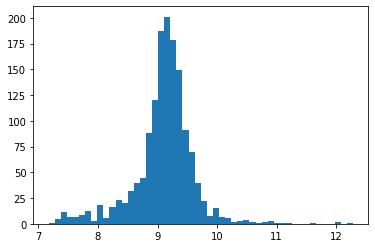

In [24]:
df['log_lotarea'] = df.lotarea.apply(np.log)
plt.hist(df.log_lotarea,bins=50)

In [25]:
la_stats = df.log_lotarea.describe()

In [26]:
mu = la_stats['mean']
std = la_stats['std']
outliers = outliers + list(df[(df.log_lotarea < mu - 3*std)|(df.log_lotarea>mu+3*std)].index)

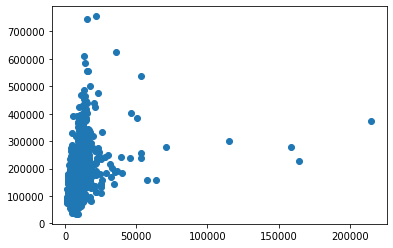

In [27]:
plt.scatter(df.lotarea,df.saleprice)

The relationship is not very linear.  I can see tow relationships, one a steep line and other almost like a square root curve that picks up the points on the right.  Because there doesn't appear to be much of a relationship, I will not look at outliers in this scatterplot but assume they were already picked up.

### Street

<AxesSubplot:title={'center':'log_saleprice'}, xlabel='street'>

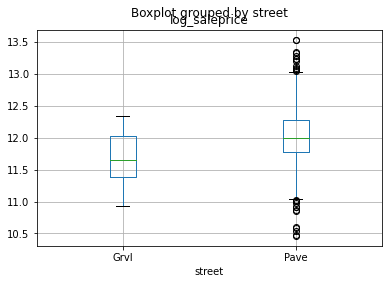

In [28]:
df.boxplot('log_saleprice','street')

In [29]:
outliers = outliers + categorical_outliers('street','log_saleprice')

### Alley

<AxesSubplot:title={'center':'log_saleprice'}, xlabel='alley'>

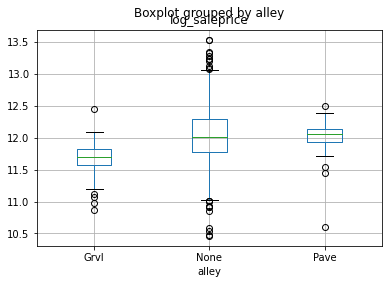

In [35]:
df.boxplot('saleprice','alley')

In [43]:
df.alley.value_counts()

None    1369
Grvl      50
Pave      41
Name: alley, dtype: int64

In [44]:
# since alleys are rare, should I look for outliers?

<AxesSubplot:>

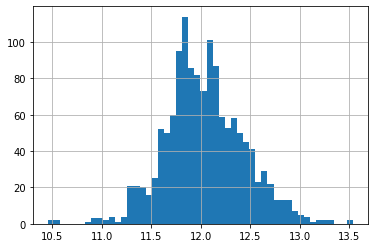

In [34]:
df[df.alley=="None"]['log_saleprice'].hist(bins=50)

# HERE

## Handling missing values